# PS7 

#### Tyler Amos

#### MACS 30100 

_March 5 2018_

In [152]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC

auto = pd.read_csv('https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS7/Auto.csv', na_values=["?"] )

# add mpg_high variable
mpg_median = np.median(auto.mpg)
high_low = lambda x: 1 if x.mpg > mpg_median else 0
mpg_high = []
for i in auto.itertuples():
    mpg_high.append(high_low(i))
auto['mpg_high'] = mpg_high
auto = auto.dropna()
x_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'constant']
auto['constant'] = 1
x_auto = auto[x_cols]
y_auto = auto['mpg_high']
x_auto_b = auto[x_cols[:-1]]
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,constant
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1


# (a) 

In [153]:
k = 4
xvars = x_auto.values
yvals = y_auto.values
kf = KFold(n_splits=k, shuffle=True, random_state=15)
kf.get_n_splits(xvars)

k_ind = int(0)

MSE_vec_kf_log = np.zeros(k)
error_vec_cat_0 = np.zeros(k)
error_vec_cat_1 = np.zeros(k)

# Borrowed from AlexanderTyan
for train_index, test_index in kf.split(xvars):
    X_train, X_test = xvars[train_index], xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf_log[k_ind] = ((y_test - y_pred) ** 2).mean()
    eval_err = precision_recall_fscore_support(y_test, y_pred)
    cat_0_precision = eval_err[0][0]
    cat_0_error_rate = 1 - cat_0_precision
    cat_1_precision = eval_err[0][1]
    cat_1_error_rate = 1 - cat_1_precision
    error_vec_cat_0[k_ind] = cat_0_error_rate
    error_vec_cat_1[k_ind] = cat_1_error_rate
    k_ind += 1
    
print("Category: mpg_high = True MSE: ", error_vec_cat_1.mean())
print("Category: mpg_high = True MSE: ", error_vec_cat_0.mean())
print("Model Overall MSE:", MSE_vec_kf_log.mean())

Category: mpg_high = True MSE:  0.12212723842924705
Category: mpg_high = True MSE:  0.08427517051817163
Model Overall MSE: 0.10459183673469388


# (b)

In [154]:
classif = RandomForestClassifier(max_features = 2, random_state=25, n_estimators = 20, bootstrap = True, oob_score = True)
classif.fit(x_auto_b, y_auto )
classif_diff = classif.oob_decision_function_[:,1] - classif.oob_decision_function_[:,0] # substract predicted vals
classif_diff[classif_diff > 0] = np.int(1)     # if positive (i.e., 1 was greater than 0)
classif_diff[classif_diff <= 0] = np.int(0) 
                                                                                   
eval_err = precision_recall_fscore_support(y_auto, classif_diff)
cat_0_precision = eval_err[0][0]
cat_1_precision = eval_err[0][1]
cat_0_error_rate = 1 - cat_0_precision
cat_1_error_rate = 1 - cat_1_precision
        
print("Category: mpg_high = True MSE: ", cat_1_error_rate.mean())
print("Category: mpg_high = False MSE: ",  cat_0_error_rate.mean())
print("Model Overall MSE:",mean_squared_error(auto['mpg_high'], classif_diff))

Category: mpg_high = True MSE:  0.09278350515463918
Category: mpg_high = False MSE:  0.05555555555555558
Model Overall MSE: 0.07397959183673469


# (c)

In [155]:
k = 4
xvars = x_auto_b.values # lose the constant
yvals = y_auto.values
kf = KFold(n_splits=k, shuffle=True, random_state=15)
kf.get_n_splits(xvars)

error_vec_true = np.zeros(k)
error_vec_false = np.zeros(k)
mse_vec = np.zeros(k)

k_i = 0
for train, test in kf.split(xvars):
    
    x_train = xvars[train]
    y_train = yvals[train]
    x_test = xvars[test]
    y_test = yvals[test]
    
    clf = SVC(C=1.0, gamma=0.2, kernel='rbf', random_state=25) # From the docs http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    clf.fit(x_train, y_train) 
    clf_pred = clf.predict(x_test)
    
    err_eval = precision_recall_fscore_support(y_test, clf_pred)
    
    cat_0_precision = eval_err[0][0]
    cat_1_precision = eval_err[0][1]
    cat_0_error_rate = 1 - cat_0_precision
    cat_1_error_rate = 1 - cat_1_precision
    
    error_vec_true[k_i] = cat_1_error_rate
    error_vec_false[k_i] = cat_0_error_rate
    mse_vec[k_i] = mean_squared_error(y_test, clf_pred)
    
    k_i += 1
    
print("Category: mpg_high = True MSE: ", cat_1_error_rate.mean())
print("Category: mpg_high = False MSE: ",  cat_0_error_rate.mean())
print("Model Overall MSE:", mse_vec.mean())

Category: mpg_high = True MSE:  0.09278350515463918
Category: mpg_high = False MSE:  0.05555555555555558
Model Overall MSE: 0.4566326530612245


/anaconda3/envs/persp_model_18/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# (d)

The Random Forest classification performs better than SVM or logistic regression. Overall the error rates are lower for Random Forest than for the other types of classifiers.

  Logistic Regression: MSE $ \approx 10$%; 
  Random Forest: MSE $ \approx 7$%; 
  SVM: MSE $ \approx 45$%

This conclusion is somewhat unusual, as generally SVM performs better with binary classification problems. Random Forest is usually superior when the number of possible categories exceeds 2. 

However, Random Forests do perform well when the number of features is relatively small, as is the case here. Furthermore, SVM can be influenced by outliers and extreme values, which are present in this dataset (see the plot below for graphical confirmation). 


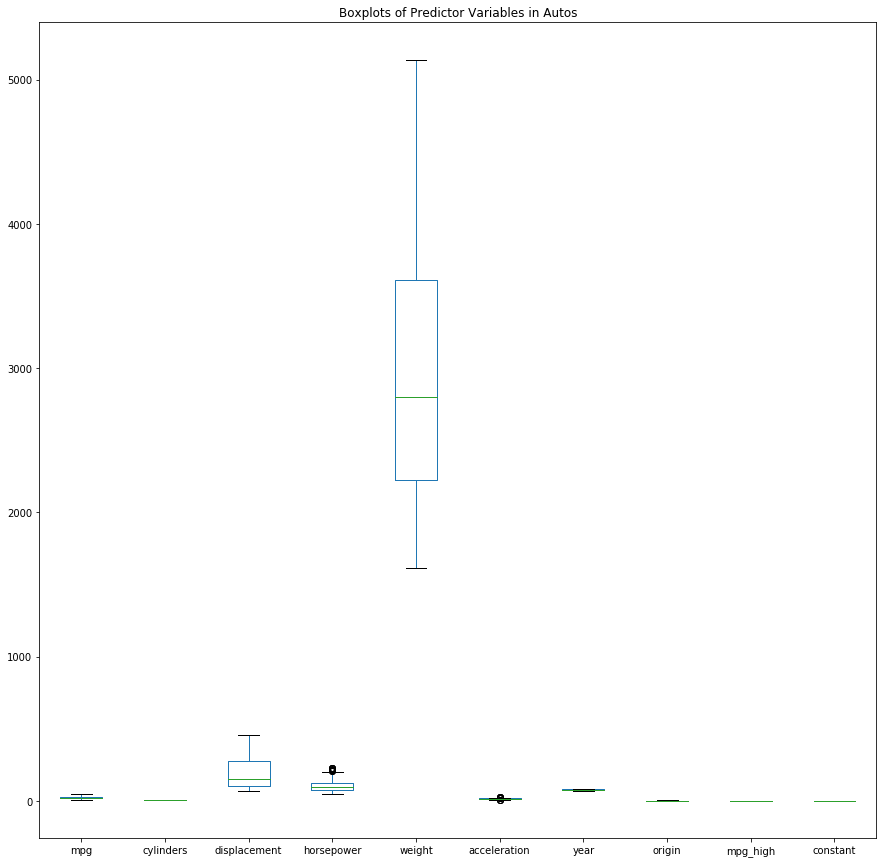

In [157]:
% matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
auto.plot(ax = ax, kind = "box", rot = 0, title = "Boxplots of Predictor Variables in Autos");